In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:


model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=512,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=4,
    n_stacks=3,
    dropout=0.3
)

print(model)

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=512, bias=True)
  (embedding_output): Linear(in_features=512, out_features=1, bias=True)
  (cont_input): Linear(in_features=4, out_features=512, bias=True)
  (output_layer): Linear(in_features=516, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (stacks): ModuleList(
    (0): NeuralStack(
      (stacks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=516, out_features=516, bias=True)
          (layer2): Linear(in_features=516, out_features=516, bias=True)
          (layer3): Linear(in_features=516, out_features=516, bias=True)
          (layer4): Linear(in_features=516, out_features=516, bias=True)
          (output): Linear(in_features=516, out_features=516, bias=True)
          (res_layer): Linear(in_features=516, out_features=516, bias=True)
          (fwr_layer)

# Loop throug each stock
Create Trainer only once

Using cuda-device
Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: <<< 0 >>>

                    Average train loss: 0.17778363227844238 | 
                    Train-Mae: 0.9772704243659973 |

                    Average val loss: 0.30430537462234497|
                    Val-Mae: 0.373491108417511
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.4490206718444824 | 
                    Train-Mae: 0.9151390194892883 |

                    Average val loss: 0.20071007311344147|
                    Val-Mae: 0.31382548809051514
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.2120297908782959 | 
                    Train-Mae: 0.8587870001792908 |

                    Average val loss: 0.14804188907146454|
                    Val-Mae: 0.2814699411392212
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Average

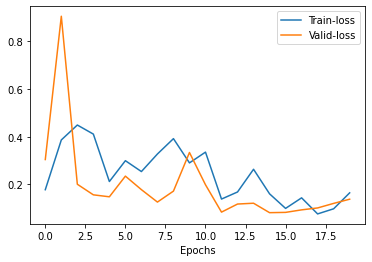

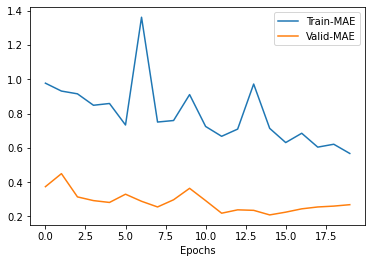

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.17805769443511962 | 
                    Train-Mae: 0.9609814882278442 |

                    Average val loss: 0.5713660717010498|
                    Val-Mae: 0.3538423478603363
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.05080130100250244 | 
                    Train-Mae: 0.8373626470565796 |

                    Average val loss: 1.1464219093322754|
                    Val-Mae: 0.4512309730052948
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.04590490460395813 | 
                    Train-Mae: 0.8401482701301575 |

                    Average val loss: 0.9049942493438721|
                    Val-Mae: 0.45356684923171997
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Average

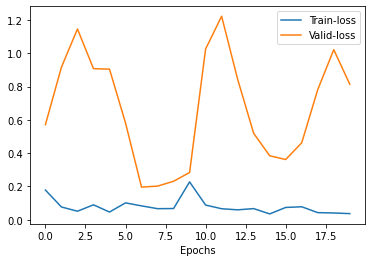

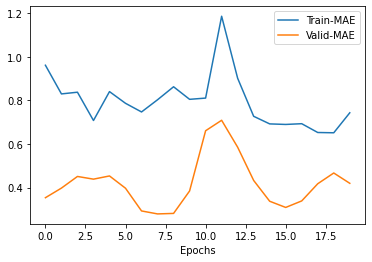

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.06469131112098694 | 
                    Train-Mae: 0.6436038017272949 |

                    Average val loss: 0.4000154435634613|
                    Val-Mae: 0.31117674708366394
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.26099231243133547 | 
                    Train-Mae: 0.7843957543373108 |

                    Average val loss: 0.1039024218916893|
                    Val-Mae: 0.18509773910045624
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.11392824649810791 | 
                    Train-Mae: 0.5220634341239929 |

                    Average val loss: 0.2028634250164032|
                    Val-Mae: 0.4012913107872009
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Averag

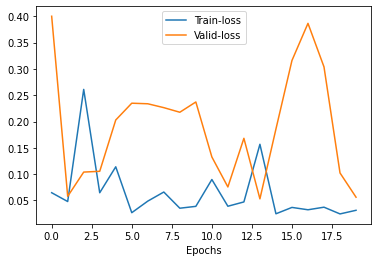

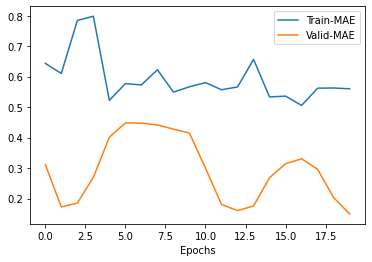

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.06025074720382691 | 
                    Train-Mae: 0.6083174347877502 |

                    Average val loss: 0.16976842284202576|
                    Val-Mae: 0.304228812456131
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.11653209924697876 | 
                    Train-Mae: 0.6550347208976746 |

                    Average val loss: 0.24819794297218323|
                    Val-Mae: 0.22868049144744873
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.05751959681510925 | 
                    Train-Mae: 0.5736410021781921 |

                    Average val loss: 0.5331701636314392|
                    Val-Mae: 0.19113488495349884
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Avera

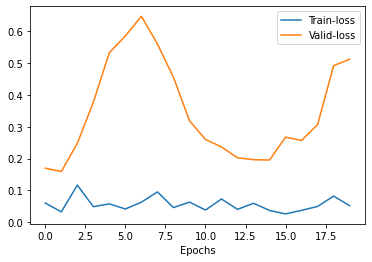

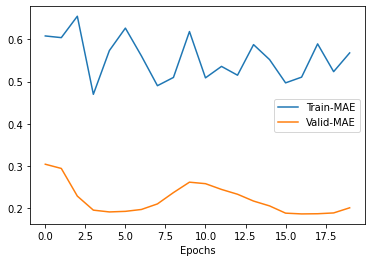

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.03935624957084656 | 
                    Train-Mae: 0.4577527642250061 |

                    Average val loss: 0.3249841630458832|
                    Val-Mae: 0.23624476790428162
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.05351411104202271 | 
                    Train-Mae: 0.46556922793388367 |

                    Average val loss: 0.24810756742954254|
                    Val-Mae: 0.28965139389038086
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.05411595106124878 | 
                    Train-Mae: 0.48939982056617737 |

                    Average val loss: 0.12884515523910522|
                    Val-Mae: 0.2732805907726288
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Av

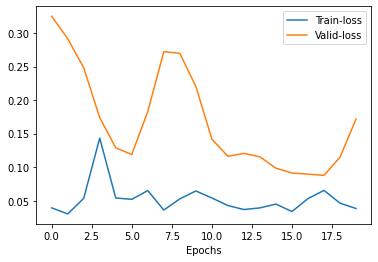

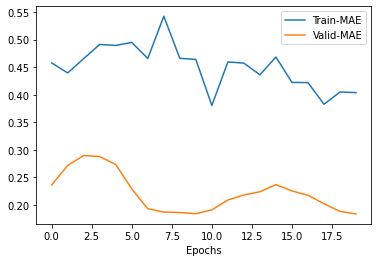

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.023345208168029784 | 
                    Train-Mae: 0.4851820766925812 |

                    Average val loss: 0.22996145486831665|
                    Val-Mae: 0.20292410254478455
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.034263765811920165 | 
                    Train-Mae: 0.4344823360443115 |

                    Average val loss: 0.19322368502616882|
                    Val-Mae: 0.20204231142997742
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.021909703314304353 | 
                    Train-Mae: 0.48387762904167175 |

                    Average val loss: 0.20252928137779236|
                    Val-Mae: 0.2756010591983795
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                   

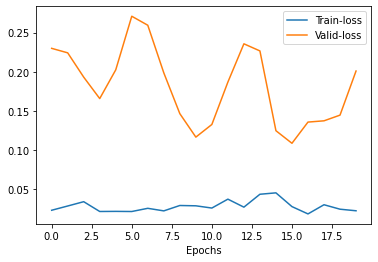

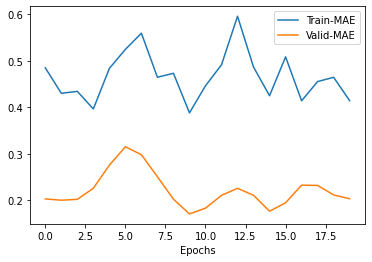

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.1590791940689087 | 
                    Train-Mae: 0.3151603639125824 |

                    Average val loss: 0.1825176179409027|
                    Val-Mae: 0.20739008486270905
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.019532236456871032 | 
                    Train-Mae: 0.36201512813568115 |

                    Average val loss: 0.14942049980163574|
                    Val-Mae: 0.22074894607067108
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.03246053457260132 | 
                    Train-Mae: 0.2966676354408264 |

                    Average val loss: 0.24978896975517273|
                    Val-Mae: 0.17448896169662476
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Av

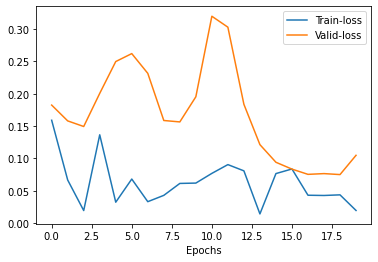

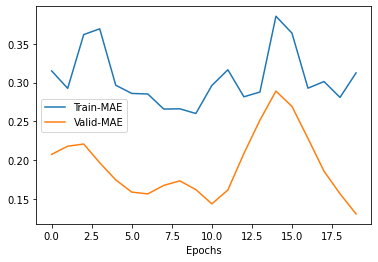

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.011612501740455628 | 
                    Train-Mae: 0.4254632890224457 |

                    Average val loss: 1.8599570989608765|
                    Val-Mae: 1.1189782619476318
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.014272239804267884 | 
                    Train-Mae: 0.3348243534564972 |

                    Average val loss: 2.748983860015869|
                    Val-Mae: 0.9693101048469543
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.02085670828819275 | 
                    Train-Mae: 0.3988765776157379 |

                    Average val loss: 14.449761390686035|
                    Val-Mae: 0.7216283082962036
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Average

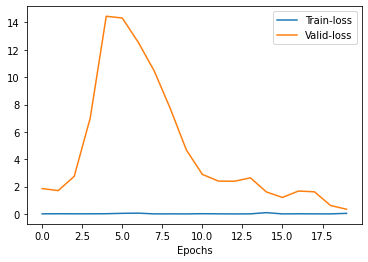

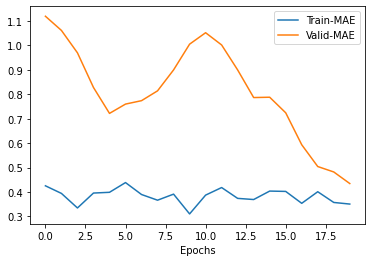

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.033390530943870546 | 
                    Train-Mae: 0.33240023255348206 |

                    Average val loss: 0.07288268953561783|
                    Val-Mae: 0.10215089470148087
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.013427114486694336 | 
                    Train-Mae: 0.3335637152194977 |

                    Average val loss: 0.06577400118112564|
                    Val-Mae: 0.0948401391506195
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0452881395816803 | 
                    Train-Mae: 0.3286137580871582 |

                    Average val loss: 0.047006942331790924|
                    Val-Mae: 0.10320863127708435
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    

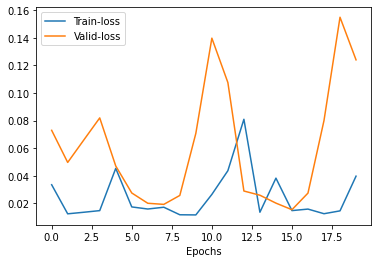

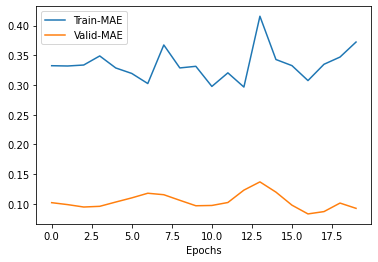

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.05279178023338318 | 
                    Train-Mae: 0.263366162776947 |

                    Average val loss: 0.2550952136516571|
                    Val-Mae: 0.15536515414714813
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.04952646493911743 | 
                    Train-Mae: 0.24075353145599365 |

                    Average val loss: 0.2011130303144455|
                    Val-Mae: 0.16344736516475677
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.05595117807388306 | 
                    Train-Mae: 0.2581174373626709 |

                    Average val loss: 0.2959780991077423|
                    Val-Mae: 0.18578340113162994
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Avera

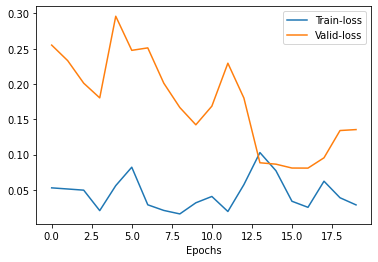

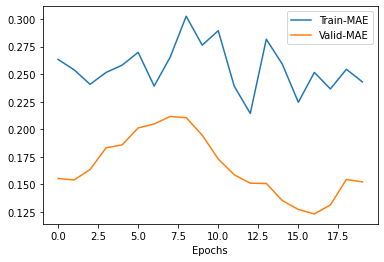

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.012900982797145844 | 
                    Train-Mae: 0.3200226128101349 |

                    Average val loss: 0.27321043610572815|
                    Val-Mae: 0.3360932469367981
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.03279874324798584 | 
                    Train-Mae: 0.31947264075279236 |

                    Average val loss: 0.4071637988090515|
                    Val-Mae: 0.33088168501853943
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.00787903293967247 | 
                    Train-Mae: 0.2870108485221863 |

                    Average val loss: 0.06720859557390213|
                    Val-Mae: 0.19909776747226715
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Av

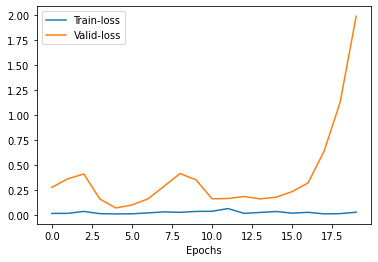

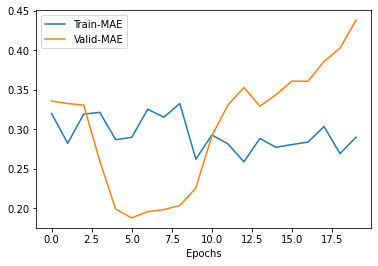

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.012713654339313507 | 
                    Train-Mae: 0.263775497674942 |

                    Average val loss: 0.5048810839653015|
                    Val-Mae: 0.13356736302375793
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.050442808866500856 | 
                    Train-Mae: 0.28762388229370117 |

                    Average val loss: 0.46581318974494934|
                    Val-Mae: 0.14023946225643158
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.08838193416595459 | 
                    Train-Mae: 0.3266832232475281 |

                    Average val loss: 0.2299395352602005|
                    Val-Mae: 0.1451881378889084
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                    Ave

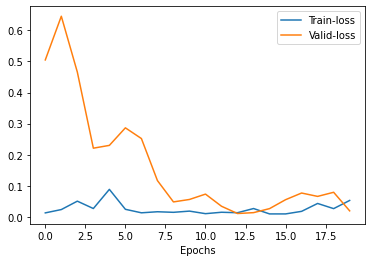

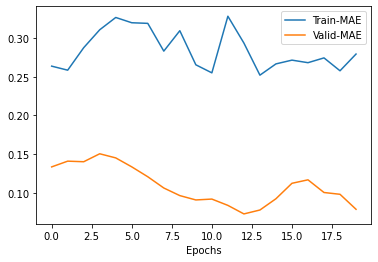

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.019242557883262634 | 
                    Train-Mae: 0.2854325771331787 |

                    Average val loss: 0.03992139920592308|
                    Val-Mae: 0.13524772226810455
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0454524040222168 | 
                    Train-Mae: 0.27417832612991333 |

                    Average val loss: 0.012814277783036232|
                    Val-Mae: 0.09335985779762268
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.01922873258590698 | 
                    Train-Mae: 0.19460861384868622 |

                    Average val loss: 0.06172410026192665|
                    Val-Mae: 0.06730092316865921
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                   

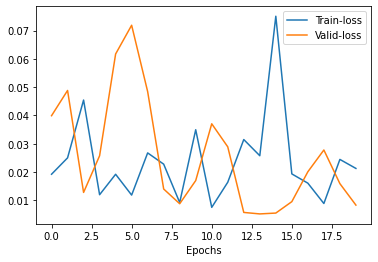

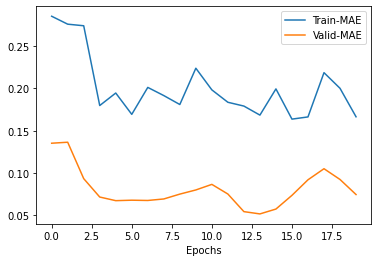

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0231625497341156 | 
                    Train-Mae: 0.20031221210956573 |

                    Average val loss: 0.06825309991836548|
                    Val-Mae: 0.11567459255456924
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.025607603788375854 | 
                    Train-Mae: 0.20583860576152802 |

                    Average val loss: 0.24708415567874908|
                    Val-Mae: 0.10922426730394363
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.05063015818595886 | 
                    Train-Mae: 0.19184380769729614 |

                    Average val loss: 0.09893058240413666|
                    Val-Mae: 0.13086532056331635
                    
.................... End of epoch 4 ....................
Epoch: <<< 6 >>>

                   

In [ ]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512

trainer = Trainer(model, optimizer_name='adam', lr=1.3333e-5)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 15:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=20
    )
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)

    